## Course Assignment Instructions
You should have Python (version 3.8 or later) and Jupyter Notebook installed to complete this assignment. You will write code in the empty cell/cells below the problem. While most of this will be a programming assignment, some questions will ask you to "write a few sentences" in markdown cells. 

Submission Instructions:

Create a labs directory in your personal class repository (e.g., located in your home directory)
Clone the class repository
Copy this Jupyter notebook file (.ipynb) into your repo/labs directory
Make your edits, commit changes, and push to your repository
All submissions must be pushed before the due date to avoid late penalties. 

Labs are graded out of a 100 pts. Each day late is -10. For a max penalty of -50 after 5 days. From there you may submit the lab anytime before the semester ends for a max score of 50.  

Lab 4 is due on 3/3/25 

Create a dataset D which we call `Xy` such that the linear model has  R² about 0\% but x, y are clearly associated.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from plotnine import ggplot, aes, geom_point, scale_y_continuous, labs, ggtitle

# Set numpy to ignore overflow warnings
np.seterr(over='ignore')

# Create x values from 1 to 200
x = np.arange(1, 201, dtype=np.float64)

# Compute y as x raised to the 67th power
y = x ** 67

# Create the DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Fit the linear model: y ~ x
X = sm.add_constant(df['x'])  # Adds an intercept
model = sm.OLS(df['y'], X).fit()
print("R-squared:", model.rsquared)

# Plot using plotnine with specified y-axis limits
p = (
    ggplot(df, aes(x='x', y='y'))
    + geom_point()
    + scale_y_continuous(limits=(-7.37e152, 20))
    + labs(x='x', y='y')
    + ggtitle('Scatter Plot of x vs y')
)

p


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide


R-squared: nan


TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

The issue is that when you compute y = x⁶⁷ on x values from 1 to 200, the resulting numbers are extremely large. Even when computed as floats, this can lead to numerical instability in the regression calculation, causing R² to become NaN. One common fix is to scale down y before fitting the model. Run the code below and see the difference. 

R-squared: 0.08604190534084832
<ggplot: (640 x 480)>


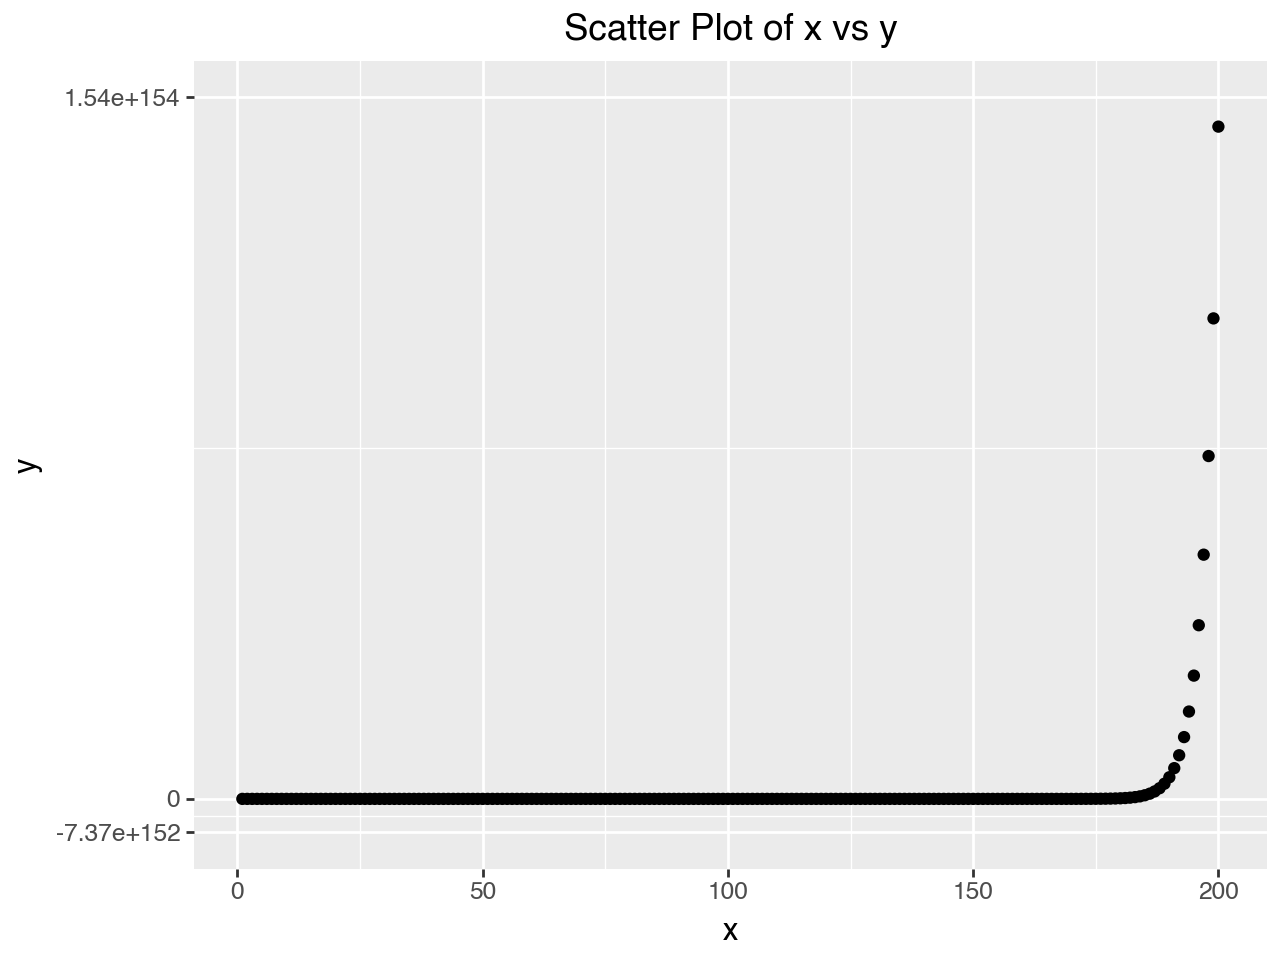

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from plotnine import ggplot, aes, geom_point, scale_y_continuous, labs, ggtitle

# Set numpy to ignore overflow warnings during exponentiation
np.seterr(over='ignore')

# Create x values as floats
x = np.arange(1, 201, dtype=np.float64)

# Compute y as x raised to the 67th power
y = x ** 67

# Scale down y for regression purposes (R² is invariant under scaling)
scaling_factor = 1e154
y_scaled = y / scaling_factor

# Build the DataFrame with original and scaled y values
df = pd.DataFrame({'x': x, 'y': y, 'y_scaled': y_scaled})

# Fit the linear model on the scaled y
X = sm.add_constant(df['x'])
model = sm.OLS(df['y_scaled'], X).fit()
print("R-squared:", model.rsquared)

# Define the y-axis limits as Python floats
y_min = float(-7.37e152)
y_max = float(1.54e154)

# Provide explicit breaks and labels to avoid automatic tick calculation issues
p = (
    ggplot(df, aes(x='x', y='y'))
    + geom_point()
    + scale_y_continuous(
          limits=(y_min, y_max),
          breaks=[y_min, 0.0, y_max],
          labels=[f"{y_min:.2e}", "0", f"{y_max:.2e}"]
      )
    + labs(x='x', y='y')
    + ggtitle('Scatter Plot of x vs y')
)

print(p)
p

Write a function `my_ols` that takes in `X`, a matrix with with p columns representing the feature measurements for each of the n units, a vector of n responses `y` and returns a list that contains the `b`, the p+1-sized column vector of OLS coefficients, `yhat` (the vector of n predictions), `e` (the vector of n residuals), `df` for degrees of freedom of the model, `SSE`, `SST`, `MSE`, `RMSE` and `Rsq` (for the  R² metric). You will have to use `linalg.inv` from numpy

In [3]:
import numpy as np
import pandas as pd

# Define a custom class to mimic R's class assignment
class MyOLSResult(dict):
    pass

def my_ols(X, y, add_intercept=True):
    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Check that X is numeric
    if not np.issubdtype(X.dtype, np.number):
        raise ValueError("X is not numeric")
    # Check that y is numeric
    if not np.issubdtype(y.dtype, np.number):
        raise ValueError("y needs to be numeric")
    # Check that the number of rows in X equals the length of y
    if X.shape[0] != len(y):
        raise ValueError("X rows and length of y need to be the same length.")
    
    n = len(y)
    
    # Add an intercept column if requested
    if add_intercept:
        X = np.column_stack((np.ones(n), X))
        
    p = X.shape[1]  # p is the number of parameters (including the intercept if added)
    df = n - p      # residual degrees of freedom
    
    if n <= p:
        raise ValueError("There must be more observations than parameters")
    
    y_bar = np.mean(y)
    
    # Compute OLS coefficients: b = (X^T X)^{-1} X^T y
    XtX = X.T @ X
    b = np.linalg.inv(XtX) @ (X.T @ y)
    
    # Compute predictions and residuals
    yhat = X @ b
    e = y - yhat
    
    # Compute SSE and SST
    SSE = e.T @ e
    SST = np.sum((y - y_bar)**2)
    
    # Compute MSE, RMSE, and R-squared
    MSE = SSE / (n - p)
    RMSE = np.sqrt(MSE)
    Rsq = 1 - (SSE / SST)
    
    # Construct the result as an instance of MyOLSResult
    result = MyOLSResult({
        'b': b,
        'yhat': yhat,
        'df': df,
        'e': e,
        'SSE': SSE,
        'SST': SST,
        'MSE': MSE,
        'RMSE': RMSE,
        'Rsq': Rsq,
        'p': p
    })
    return result


In [4]:
%pip install pydataset

Note: you may need to restart the kernel to use updated packages.


Verify that the OLS coefficients for the `Type` of cars in the cars dataset gives you the same results as we did in class (i.e. the ybar's within group). You will load the cars data set by importing data from pydataset 

In [5]:
from pydataset import data

# Load the Cars93 dataset (equivalent to MASS::Cars93)

cars = data("Cars93")

# Create a design matrix for Type with no intercept,
# similar to model.matrix(~ 0 + Type, data = cars) in R.

X = pd.get_dummies(cars['Type'], prefix = 'Type', drop_first = False).astype(float)

# Get the Price vector
y = cars['Price'].to_numpy()


# Run our custom OLS function with add_intercept set to False
result = my_ols(X, y, add_intercept=False)
print(result)

{'b': array([18.2125    , 24.3       , 27.21818182, 10.16666667, 19.39285714,
       19.1       ]), 'yhat': array([10.16666667, 27.21818182, 18.2125    , 27.21818182, 27.21818182,
       27.21818182, 24.3       , 24.3       , 27.21818182, 24.3       ,
       27.21818182, 18.2125    , 18.2125    , 19.39285714, 27.21818182,
       19.1       , 19.1       , 24.3       , 19.39285714, 24.3       ,
       18.2125    , 24.3       , 10.16666667, 10.16666667, 18.2125    ,
       19.1       , 27.21818182, 19.39285714, 10.16666667, 24.3       ,
       10.16666667, 10.16666667, 18.2125    , 19.39285714, 19.39285714,
       19.1       , 27.21818182, 24.3       , 10.16666667, 19.39285714,
       19.39285714, 10.16666667, 18.2125    , 10.16666667, 10.16666667,
       19.39285714, 27.21818182, 27.21818182, 27.21818182, 27.21818182,
       27.21818182, 24.3       , 10.16666667, 10.16666667, 18.2125    ,
       19.1       , 19.39285714, 18.2125    , 27.21818182, 19.39285714,
       27.21818182, 10.16666

Create a prediction method `g` that takes in a vector `x_star` and the dataset D i.e. `X` and `y` and returns the OLS predictions. Let `X` be a matrix with with p columns representing the feature measurements for each of the n units


In [6]:
import numpy as np

def g(x_star, X, y, add_intercept=True):
    """
    Prediction function that returns the OLS prediction for a new observation.
    
    Parameters:
        x_star : array-like
            A vector of feature values for the new observation.
        X : array-like
            The design matrix for the training data.
        y : array-like
            The response vector for the training data.
        add_intercept : bool (default True)
            Whether the my_ols function should add an intercept.
    
    Returns:
        The OLS prediction for x_star.
    """
    # Get the OLS result from our custom function
    result = my_ols(X, y, add_intercept=add_intercept)
    b = result['b']    
    # Ensure x_star is a numpy array
    x_star = np.array(x_star)
    
    # If an intercept was added in the model, prepend a 1 to x_star.
    if add_intercept:
        x_star = np.concatenate(([1], x_star))
    # Return the dot product (prediction)
    return np.dot(x_star,b)

# Create a design matrix for Type with no intercept, and force numeric conversion
X = pd.get_dummies(cars['Type'], prefix='Type', drop_first=False).astype(float)
y = cars['Price'].to_numpy()

# Convert X to a NumPy array so that indexing works as expected
X_np = X.to_numpy()

# Now, predict for the first observation in X using our custom function g
prediction = g(X_np[0, :], X_np, y, add_intercept=False)
print(prediction)

10.166666666666666


Load up the famous iris dataset. We are going to do a different prediction problem. Imagine the only input x is Species and you are trying to predict y which is Petal.Length. A reasonable prediction is the average petal length within each Species. Prove that this is the OLS model by fitting an appropriate `ols` and then using the `mod.predict` function to verify. Note: this time we will load the iris dataset from another python package called seaborn which we will cover in depth during lab 6 when we go over visualizations. 

In [7]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

# Load the iris dataset from seaborn
iris = sns.load_dataset("iris")

# Optionally, rename columns to match the R names (Petal.Length becomes Petal_Length and Species stays Species)
iris.rename(columns={"petal_length": "Petal_Length", "species": "Species"}, inplace=True)

# Fit the OLS model: Petal_Length ~ Species.
# This will create dummy variables internally and use one species as the baseline.
mod = smf.ols("Petal_Length ~ Species", data = iris).fit()

# Compute the mean Petal_Length within each Species
mean_setosa = iris.loc[iris["Species"] == "setosa", "Petal_Length"].mean()
mean_versicolor = iris.loc[iris["Species"] == "versicolor", "Petal_Length"].mean()
mean_virginica = iris.loc[iris["Species"] == "virginica", "Petal_Length"].mean()


print("Mean Petal_Length for setosa: ", mean_setosa)
print("Mean Petal_Length for versicolor: ", mean_versicolor)
print("Mean Petal_Length for virginica: ", mean_virginica)


# Use predict to obtain predictions for each Species.
pred_setosa = mod.predict(pd.DataFrame({"Species": ["setosa"]}))
pred_versicolor = mod.predict(pd.DataFrame({"Species": ["versicolor"]}))
pred_virginica = mod.predict(pd.DataFrame({"Species": ["virginica"]}))

print("Predicted Petal_Length for setosa: ", pred_setosa.iloc[0])
print("Predicted Petal_Length for versicolor: ", pred_versicolor.iloc[0])
print("Predicted Petal_Length for virginica: ", pred_virginica.iloc[0])



Mean Petal_Length for setosa:  1.4620000000000002
Mean Petal_Length for versicolor:  4.26
Mean Petal_Length for virginica:  5.5520000000000005
Predicted Petal_Length for setosa:  1.4619999999999929
Predicted Petal_Length for versicolor:  4.260000000000003
Predicted Petal_Length for virginica:  5.552000000000001


You may have noticed that to get the OLS function from statsmodel we used smf instead of sm. Either method can be used but the
difference is in the interface they provide:

sm (statsmodels.api):
This is the lower-level API where you work directly with data arrays or matrices. You have to manually create the design matrix (including adding an intercept if needed), and then pass it to functions like sm.OLS. This interface is similar to using raw matrix algebra.

smf (statsmodels.formula.api):
This offers a higher-level, formula-based interface (similar to R's lm), where you can specify your model using a formula string (e.g., "y ~ x") and a DataFrame. The function automatically constructs the design matrix and handles categorical variables.

Construct the design matrix with an intercept, X manually. You will need to use np.column_stack

In [9]:
# Construct the design matrix manually:
# - The first column is an intercept (all ones)
# - The second column is 1 if species is "versicolor", else 0
# - The third column is 1 if species is "virginica", else 0
X = np.column_stack((
    np.ones(len(iris)),
    (iris['Species'] == "versicolor").astype(int),
    (iris['Species'] == "virginica").astype(int)
))

# Show the first few rows of the design matrix
print(X[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


We now import the diamonds dataset from plotnine.data. In R you Skim the dataset using skimr or summary. Here we will use .info() and/or .describe from pandas. What is the datatype of the color feature? (hint: use .dtype on the color feature from the dataframe.)

In [10]:
import pandas as pd
from plotnine.data import diamonds

df = diamonds.copy()
print(df.head())
print(df.describe())
print(df.info())
print(df['color'].dtype)


   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
              carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000  

Find the levels of the color feature. Using pandas this can be accomplished by assigning the feature "color" to a variable by using .cat.categories from pandas.

In [11]:
# Get the levels (categories) of the 'color' feature.
levels = df['color'].cat.categories
print(levels)

Index(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype='object')


Create new feature in the diamonds dataset, `color_as_numeric`, which is color expressed as a continuous interval value. Use .cat.codes from pandas.

In [12]:
# Create a new feature 'color_as_numeric' with 1-based coding (like R)
df['color_as_numeric'] = df['color'].cat.codes + 1  

print(df[["color", "color_as_numeric"]].head())


  color  color_as_numeric
0     E                 2
1     E                 2
2     E                 2
3     I                 6
4     J                 7


Use that converted feature as the one predictor in a regression. How well does this regression do as measured by RMSE? Use sm from statsmodels.api

In [13]:
import statsmodels.api as sm

X = df['color_as_numeric']
y = df['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

predictions = model.predict(X)

residuals = y - predictions

RMSE = np.sqrt(np.mean(residuals**2))

print("RMSE: ", RMSE)

RMSE:  3929.5920511358545


Try this again using smf from statsmodels.api and see if the result matches the previous cell

In [14]:
import statsmodels.formula.api as smf

model = smf.ols("price  ~ color_as_numeric", data = df).fit()

predictions = model.predict(df)

residuals = df['price'] - predictions

RMSE = np.sqrt(np.mean(residuals**2))

print("RMSE: ", RMSE)

RMSE:  3929.5920511358545


Create new feature in the diamonds dataset, `color_as_nominal`, which is color expressed as a nominal categorical variable. Use .Categorial and set ordered = False

In [15]:
# Create a new feature 'color_as_nominal' as a nominal (unordered) categorical variable

df['color_as_nominal'] = pd.Categorical(df['color'], ordered = False)

print(df['color_as_nominal'].dtype)
print(df['color_as_nominal'].head())

#Creating the Nominal Feature:
#We use pd.Categorical to convert the "color" column into a categorical variable. 
#By setting ordered=False, we ensure it is treated as nominal (unordered).

category
0    E
1    E
2    E
3    I
4    J
Name: color_as_nominal, dtype: category
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']


Use that converted feature as the one predictor in a regression. How well does this regression do as measured by RMSE?

In [16]:
model = smf.ols("price ~ color_as_nominal", data = df).fit()
predictions = model.predict(df)

residuals = df['price'] - predictions

RMSE = np.sqrt(np.mean(residuals**2))

print("RMSE: ", RMSE)


RMSE:  3926.5220667783205


Which regression does better - `color_as_numeric` or `color_as_nominal`? Why?

color_as_nominal is slightly better because the RMSE is a bit smaller and because of autocorrelation.

Now regress both `color_as_numeric` and `color_as_nominal` in a regression. Does this regression do any better (as gauged by RMSE) than either color_as_numeric` or `color_as_nominal` alone?

In [17]:
# Model using both predictors
model_for_both = smf.ols("price ~ color_as_nominal + color_as_numeric", data = df).fit()
predictions = model_for_both.predict(df)

residuals = df['price'] - predictions

RMSE = np.sqrt(np.mean(residuals**2))

print("RMSE: ", RMSE)

RMSE:  3926.7436123691264


What are the coefficients (the b vector)? You can access the parameters using .params and assigning it to a variable `b` 

In [18]:
# Extract the coefficient vector (b vector)
b = model_for_both.params
print(b)

Intercept                3.970620e+13
color_as_nominal[T.E]    3.970620e+13
color_as_nominal[T.F]    7.941241e+13
color_as_nominal[T.G]    1.191186e+14
color_as_nominal[T.H]    1.588248e+14
color_as_nominal[T.I]    1.985310e+14
color_as_nominal[T.J]    2.382372e+14
color_as_numeric        -3.970620e+13
dtype: float64


Your Python results should be very similar to what you'd expect in R. The slight differences can be attributed to a few factors:

Factor Level Ordering:
R and Python (via pandas) may assign the underlying integer codes to factor levels in slightly different orders depending on the default level ordering. This can affect the dummy coding and, as a result, the estimated coefficients.

Numerical Precision and Implementation:
The linear algebra routines in R and Python (via NumPy/statsmodels) may differ slightly in numerical precision or the way they handle floating‐point arithmetic. These differences can lead to small discrepancies in coefficient estimates.

Contrast Coding Differences:
R’s default dummy coding (treatment contrasts) and statsmodels’ handling of categorical variables (which also uses treatment coding by default) are conceptually similar but might differ in subtle details (e.g., which level is chosen as the baseline).

Overall, the estimates are close enough that these differences are within the range expected from using different software implementations for the same model.

Something appears to be anomalous in the coefficients. What is it? Why?

It is why because the matrix want to be full rank and color_as_numeric is a redudent with color_as_nomial.


Return to the iris dataset. Find the hat matrix H for this regression.

In [19]:
from numpy.linalg import inv, matrix_rank

# Construct the design matrix X:
# 1 for the intercept, then indicators for Species == "versicolor" and Species == "virginica"
X = np.column_stack((
    (iris['Species'] == "setosa").astype(int),
    (iris['Species'] == "versicolor").astype(int),
    (iris['Species'] == "virginica").astype(int)
))

# Compute the hat matrix H = X (X^T X)^{-1} X^T
H = X @ inv(X.T @ X)@ X.T

# Compute the rank of H
rank_H = matrix_rank(H)
print("Rank of H:", rank_H)

Rank of H: 3


Verify this hat matrix is symmetric using the `assert_allclose` from `npt` from numpy.testing.

In [20]:
import numpy.testing as npt

npt.assert_allclose(H, H.T, atol = 1e-17)

In [21]:
try:
    npt.assert_allclose(H, H.T, atol = 1e-17)
    print("Hat matrix is symmetric.")
except AssertionError as e:
    print("Hat matrix is not symmetric:", e)

Hat matrix is symmetric.


Verify this hat matrix is idempotent using the `assert_allclose` from `npt` from numpy.testing.

In [22]:
npt.assert_allclose(H,H @ H , atol = 1e-17)

In [23]:
try:
    npt.assert_allclose(H,H @ H , atol = 1e-17)
    print("Hat matrix is idempotent.")
except AssertionError as e:
    print("Hat matrix is not idempotent", e)

Hat matrix is idempotent.


Using the `np.diag` function from numpy, find the trace of the hat matrix (i.e. the sum of the diagonal elements in the matrix). 

In [24]:
# Given H is your hat matrix
trace_of_H = np.sum(np.diag(H))
print("Trace of H:", trace_of_H)

Trace of H: 3.0


It turns out the trace of a hat matrix is the same as its rank! But we don't have time to prove these interesting and useful facts..

Extra Credit (+5): create a matrix X-perpendicular

In [25]:
# Assume H and X have been defined previously.


Using the hat matrix, compute the yhat vector and using the projection onto the residual space, compute the e vector and verify they are orthogonal to each other.

In [26]:
# Get the response vector: equivalent to iris$Petal.Length in R
y = iris['Petal_Length'].to_numpy()
y_hat = H @ y
# In R, table(y_hat) is used to inspect the fitted values.
# Here we can mimic this by computing unique rounded values and their counts.
unique_vals, counts = np.unique(np.round(y_hat, 2), return_counts=True)
print("Table of y_hat (rounded to 2 decimals):")
for val, count in zip(unique_vals, counts):
    print(f"{val}: {count}")

# Compute the residuals using the projection onto the residual space:
# e = (I - H) %*% y, where I is the identity matrix.
I = np.eye(iris.shape[0])
e = (I - H) @ y

print("\nFirst 10 residuals (e):")
print(e[:10])

# Check orthogonality: the dot product of y_hat and e should be nearly zero.
dot_product = np.dot(y_hat, e)
print("\nDot product of y_hat and e (should be near 0):")
print(dot_product)


Table of y_hat (rounded to 2 decimals):
1.46: 50
4.26: 50
5.55: 50

First 10 residuals (e):
[-0.062 -0.062 -0.162  0.038 -0.062  0.238 -0.062  0.038 -0.062  0.038]

Dot product of y_hat and e (should be near 0):
-5.1465946171447285e-14


Compute SST, SSR and SSE and R² and then show that SST = SSR + SSE.

In [27]:
# Compute SSE: sum of squared errors
SSE = np.dot(e, e)

# Compute y_bar: mean of y
y_bar = np.mean(y)

# Compute SST: total sum of squares
SST = np.dot(y - y_bar, y - y_bar)

# Compute SSR: regression sum of squares
SSR = np.dot(y_hat - y_bar, y_hat-y_bar)

print("SSR:", SSR)
print("SSE:", SSE)
print("SST:", SST)

# Verify that SST equals SSR + SSE within a tolerance
npt.assert_allclose(SSR + SSE, SST, atol = 1e-10)
print("Verified: SST equals SSR + SSE.")

# Compute R² as SSR / SST
R_squared = SSR / SST
print("R²:", R_squared)

SSR: 437.1027999999997
SSE: 27.222599999999986
SST: 464.3254
Verified: SST equals SSR + SSE.
R²: 0.9413717190573674


Find the angle theta between y - ybar 1 and yhat - ybar 1 and then verify that its cosine squared is the same as the R² from the previous problem.

In [28]:
# Compute the dot product of (y - y_bar) and (y_hat - y_bar)
numerator = np.dot(y - y_bar, y_hat - y_bar)
# Compute the denominator: sqrt(SST * SSR)
denominator = np.sqrt(SST * SSR )

# Compute theta in radians using arccos
theta = np.arccos(numerator / denominator)

# Convert theta to degrees
theta_degree = theta * 180 / np.pi

print("Theta (in radians):", theta)
print("Theta (in degrees):", theta_degree)

# Verify that cos^2(theta) is equal to R²
cos_squared_theta = np.cos(theta)**2

print("cos^2(theta):", cos_squared_theta)
print("R²:", R_squared)

Theta (in radians): 0.2445634368080682
Theta (in degrees): 14.012452752316717
cos^2(theta): 0.9413717190573685
R²: 0.9413717190573674


Project the y vector onto each column of the X matrix and test if the sum of these projections is the same as yhat. Use `assert_allclose` from numpy (This should fail)

In [29]:
# Projection onto the first column of X
proj_1 = (X[:, 0:1] @ X[:, 0:1].T) / (np.dot(X[:, 0], X[:, 0])) @ y
proj_2 = (X[:, 1:2] @ X[:, 1:2].T) / (np.dot(X[:, 1], X[:, 1])) @ y
proj_3 = (X[:, 2:3] @ X[:, 2:3].T) / (np.dot(X[:, 2], X[:, 2])) @ y

projections_sum = proj_1 + proj_2 + proj_3

np.assert_allclose(projections_sum, y_hat, atol = 1e-7)
print("The sum of the projections equals yhhat")

AttributeError: module 'numpy' has no attribute 'assert_allclose'

Construct the design matrix without an intercept, X, without using pandas DataFrame.

In [30]:
# Construct the design matrix without an intercept:
# Each column is an indicator (dummy variable) for one species.

x = np.column_stack((
    (iris['Species'] == "setosa").astype(int),
    (iris['Species'] == "versicolor").astype(int),
    (iris['Species'] == "virginica").astype(int)
))
# The response vector is petal_length.
y = iris["Petal_Length"].values



Find the OLS estimates using this design matrix. It should be the sample averages of the petal lengths within species.

In [31]:
# C"omputing the hat matrix for x
H_2 = x @ np.linalg.inv(x.T @ x) @ x.T
# The fitted values using H_2
yhat_ni = H_2 @ y 

X = np.column_stack((
    np.ones(len(iris)),
    (iris['Species'] == "versicolor").astype(int),
    (iris['Species'] == "virginica").astype(int)
))

# compute hat matrix for H
H = X @ np.linalg.inv(X.T @ X) @ X.T
yhat = H @ y

print(yhat_ni)
print(yhat)

unique_yhat_ni = np.unique(np.round(yhat_ni, 3))
unique_yhat = np.unique(np.round(yhat,3))

print(unique_yhat_ni)
print(unique_yhat)

ave_setosa = np.mean(iris.loc[iris['Species'] == "setosa", "Petal_Length"])
ave_versicolor = np.mean(iris.loc[iris['Species'] == "versicolor", "Petal_Length"])
ave_virginica = np.mean(iris.loc[iris['Species'] == "virginica", "Petal_Length"])

print(ave_setosa)
print(ave_versicolor)
print(ave_virginica)



[1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462
 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462
 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462
 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462
 1.462 1.462 4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26
 4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26
 4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26
 4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26  4.26
 4.26  4.26  4.26  4.26  5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552
 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552
 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552
 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552 5.552
 5.552 5.552 5.552 5.552 5.552 5.552]
[1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462 1.462
 1.462 1.462 1.46

Verify the hat matrix constructed from this design matrix is the same as the hat matrix constructed from the design matrix with the intercept by using `assert_allclose`. (Fact: orthogonal projection matrices are unique).

In [32]:
# Verify that the two hat matrices are equal within numerical tolerance.
npt.assert_allclose(H, H_2, rtol=1e-7, atol =1e-10)

Project the y vector onto each column of the X matrix and test if the sum of these projections is the same as yhat.

In [33]:
# Assuming H2 and y have already been computed (from previous steps),
# and yhatnew was computed as H2 @ y.
y_proj = H @ y

# Verify that the projection of y via H2 equals yhatnew
npt.assert_allclose(y_proj, y_hat, rtol = 1e-7, atol =1e-10)

Convert this design matrix into Q, an orthonormal matrix.

In [34]:
# Compute the QR decomposition of x. Q is the orthonormal matrix.
Q, R = np.linalg.qr(x) #tuple unpacking to assign Q (the orthonormal matrix) and R(the upper triangular matrix)

# Check normalization: Each column of Q should have unit length.
print("Sum of squares of Q[:,0]:", np.sum(Q[:, 0]**2))
print("Sum of squares of Q[:,1]:", np.sum(Q[:, 1]**2))
print("Sum of squares of Q[:,2]:", np.sum(Q[:, 2]**2))

# Check orthogonality: Dot products between different columns should be 0.
print("Dot product Q[:,0] and Q[:,1]:", np.dot(Q[:, 0], Q[:, 1]))
print("Dot product Q[:,0] and Q[:,2]:", np.dot(Q[:, 0], Q[:, 2]))
print("Dot product Q[:,2] and Q[:,1]:", np.dot(Q[:, 2], Q[:, 1]))


Sum of squares of Q[:,0]: 1.0
Sum of squares of Q[:,1]: 1.0
Sum of squares of Q[:,2]: 1.0000000000000002
Dot product Q[:,0] and Q[:,1]: 0.0
Dot product Q[:,0] and Q[:,2]: 0.0
Dot product Q[:,2] and Q[:,1]: 0.0


Project the y vector onto each column of the Q matrix and test if the sum of these projections is the same as yhat.

In [35]:
# Compute the projection onto each column of Q.
# Since Q is orthonormal, Q[:,i].T @ Q[:,i] == 1, so:
proj1 = (Q[:, 0:1] @ Q[:, 0:1].T) @ y
proj2 = (Q[:, 1:2] @ Q[:, 1:2].T) @ y
proj3 = (Q[:, 2:3] @ Q[:, 2:3].T) @ y


# Sum the individual projections.
yhatQ = proj1 + proj2 + proj3

# Alternatively, since Q is orthonormal, we can compute:
yhatQ_direct = Q @ Q.T @ y

# Verify that yhatQ equals yhatnew.
npt.assert_allclose(yhatQ, yhat_ni, rtol=1e-7, atol=1e-10)
npt.assert_allclose(yhatQ_direct, yhat_ni, rtol=1e-7, atol=1e-10)
print("The projection using Q equals yhatnew.")

The projection using Q equals yhatnew.


Find the p=3 linear OLS estimates if Q is used as the design matrix using the `sm.OLS` from statsmodels. Is the OLS solution the same as the OLS solution for X?

In [36]:
# Construct the design matrix x without an intercept:
# Each column is an indicator for one species.
x = np.column_stack((
    (iris['Species'] == "setosa").astype(int),
    (iris['Species'] == "versicolor").astype(int),
    (iris['Species'] == "virginica").astype(int)
))

Q, R = np.linalg.qr(x)

y = iris['Petal_Length'].values

modq = sm.OLS(y, Q).fit()

print(modq.params)
print(modq.summary())




[-10.33790114 -30.12274888 -39.25856849]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1180.
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           2.86e-91
Time:                        00:56:38   Log-Likelihood:                -84.847
No. Observations:                 150   AIC:                             175.7
Df Residuals:                     147   BIC:                             184.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         

Use the predict function and ensure that the predicted values are the same for both linear models: the one created with X  as its design matrix and the one created with Q as its design matrix.

In [37]:
# Assign column names to the design matrix (no intercept)
col_names = ["setosa", "versicolor", "virginica"]

# Create DataFrames for x and Q
df_x = pd.DataFrame(x, columns=col_names)
df_q = pd.DataFrame(Q, columns=col_names)

# Fit the OLS models with no intercept (since x and Q already have no intercept column)
mod3 = sm.OLS(y, df_x).fit()
mod4 = sm.OLS(y, df_q).fit()

# Use the predict method to get the fitted values
pred_mod3 = mod3.predict(df_x)
pred_mod4 = mod4.predict(df_q)


# Get the unique predicted values (rounded for numerical stability)
unique_mod3 = np.unique(np.round(pred_mod3, 3))
unique_mod4 = np.unique(np.round(pred_mod4, 3))

print("Unique predictions from mod3 (using x):", unique_mod3)
print("Unique predictions from mod4 (using Q):", unique_mod4)

Unique predictions from mod3 (using x): [1.462 4.26  5.552]
Unique predictions from mod4 (using Q): [1.462 4.26  5.552]


Load the boston housing data and extract X and y. The dimensions are n = 506 and p = 13. Create a matrix that is (p + 1) x (p + 1) full of NA's. Label the columns the same columns as X. Do not label the rows. For the first row, find the OLS estimate of the y regressed on the first column only and put that in the first entry. For the second row, find the OLS estimates of the y regressed on the first and second columns of X only and put them in the first and second entries. For the third row, find the OLS estimates of the y regressed on the first, second and third columns of X only and put them in the first, second and third entries, etc. For the last row, fill it with the full OLS estimates.

In [38]:
# Load the Boston housing data from the provided URL
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

# The dataset is stored in two alternating rows.
# The first row of each pair contains predictor values,
# the second row contains the response (target) as well as extra predictors.
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Number of observations
n = data.shape[0]

# Construct the design matrix X with an intercept:
# First column is ones, then the 13 predictors.
X = np.hstack((
    np.ones((n, 1)),
    data
))
y = target

# Create column names: "Intercept" plus the 13 predictor names.
# (Using the standard Boston dataset names)
col_names = np.concatenate((["Intercept"], 
                            ["CRIM", "ZN", "INDUS", "CHAS", "NOX", 
                             "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]))

# Create a (p+1)x(p+1) matrix (14x14) filled with np.nan
M = np.full((X.shape[1], X.shape[1]), np.nan)

# For each i from 1 to 14, compute the OLS estimates using the first i columns of X.
for i in range(1, X.shape[1] + 1):
    b = np.full(X.shape[1], np.nan)  # Temporary vector of length 14 filled with np.nan
    X2 = X[:, :i]  # Use the first i columns of X
    # Compute OLS estimate: beta = (X2^T X2)^{-1} X2^T y
    beta = np.linalg.inv(X2.T @ X2) @ (X2.T @ y)
    b[:i] = beta  # Place the estimates in the first i entries
    M[i-1, :] = b

# Convert M to a DataFrame and label its columns
M_df = pd.DataFrame(M, columns=col_names)
print(M_df)



    Intercept      CRIM        ZN     INDUS      CHAS        NOX        RM  \
0   22.532806       NaN       NaN       NaN       NaN        NaN       NaN   
1   24.033106 -0.415190       NaN       NaN       NaN        NaN       NaN   
2   22.485628 -0.352078  0.116109       NaN       NaN        NaN       NaN   
3   27.394647 -0.248628  0.058501 -0.415578       NaN        NaN       NaN   
4   27.112803 -0.228798  0.059287 -0.440325  6.894059        NaN       NaN   
5   29.489941 -0.218519  0.055110 -0.383481  7.026223  -5.424659       NaN   
6  -17.954635 -0.176914  0.021281 -0.143653  4.784684  -7.184892  7.341586   
7  -18.264926 -0.172761  0.014214 -0.130899  4.840730  -4.357411  7.386357   
8    0.827482 -0.197787  0.060993 -0.225731  4.577598 -14.451531  6.752352   
9    0.155391 -0.178040  0.060952 -0.210043  4.536648 -13.342666  6.791184   
10   2.990787 -0.179554  0.071456 -0.104377  4.110667 -12.591596  6.664084   
11  27.152368 -0.184032  0.039100 -0.042324  3.487528 -22.182110

Why are the estimates changing from row to row as you add in more predictors?

The estimates are changing from row to row as you add in more predictors because the model is adjusting as it takes in the additional data to return a better fitting line.

Create a vector of length p+1 and compute the R² values for each of the above models. 

In [39]:
# Compute ybar and SST
ybar = np.mean(y)
SST = np.sum((y-ybar)**2)

# Initialize an array to hold the R² values for each model (there are 14 models)
Rsq = np.empty(14) 

# Loop over i = 1 to 14 (each row of M corresponds to a model with the first i predictors)
p_plus_1 = M.shape[0]  # This should be 14
for i in range(1, p_plus_1 + 1):
    # Create a coefficient vector of length 14.
    # Use the first i coefficients from M (row i-1) and pad the rest with zeros.
    b = np.concatenate((M[i-1, :i], np.zeros(p_plus_1 - i)))
    
    # Compute the fitted values for the full design matrix X using these coefficients
    yhat = X @ b
    
    # Compute the regression sum of squares (SSR)
    SSR = np.sum((yhat - ybar)**2)
    # Compute R² as SSR / SST
    Rsq[i-1] = SSR/SST

print("R² values for each model:")
print(Rsq)

R² values for each model:
[3.73781120e-30 1.50780469e-01 2.33988438e-01 2.93713572e-01
 3.29527723e-01 3.31312701e-01 5.87376962e-01 5.89490158e-01
 6.31148759e-01 6.31947853e-01 6.39662803e-01 6.70314088e-01
 6.84204280e-01 7.40642664e-01]


Is R² monotonically increasing? Why?

Yes. because when we add additional predictors, it provides additional flexibility to the model which means that the models get better. SSE also smaller and Rsq becomes greater. If the new predictors do not contribute to the model, the Rsq will not increase nor decrease. 

Create a 2x2 matrix with the first column 1's and the next column iid normals. Find the absolute value of the angle (in degrees, not radians) between the two columns in absolute difference from 90 degrees. 

In [40]:
def norm_vec(v):
    return np.sqrt(np.sum(v**2))

# Create a 2x2 matrix: first column is all ones; second column is iid N(0,1)
X = np.ones((2,2))
X[:, 1] = np.random.randn(2)

# Compute the cosine of the angle between the first and second column
cos_theta = np.dot(X[:, 0], X[:, 1]) / (norm_vec(X[:, 0]) * norm_vec(X[:, 1]))
print("Cosine of the angle:", cos_theta)

# Compute the angle in degrees
angle_degrees = np.arccos(cos_theta) * 180 / np.pi
print("Angle between columns (degrees):", angle_degrees)

# Compute the absolute difference from 90 degrees
abs_diff = abs(90-angle_degrees)
print("Absolute difference from 90 degrees:", abs_diff)

Cosine of the angle: 0.3774484250637729
Angle between columns (degrees): 67.8242784791551
Absolute difference from 90 degrees: 22.175721520844903


Repeat this exercise `Nsim = 1e5` times and report the average absolute angle.

In [41]:
Nsim = int(1e5)
angles = np.empty(Nsim)

for i in range(Nsim):
    # Construct a 2x2 matrix: first column is all ones, second column is two iid normals.
    X = np.ones((2, 2))
    X[:, 1] = np.random.randn(2)
    
    # Compute cosine of the angle between the two columns.
    cos_theta = np.dot(X[:, 0], X[:, 1]) / (norm_vec(X[:, 0]) * norm_vec(X[:, 1]))
    
    # Compute the angle in degrees.
    angle = np.arccos(cos_theta) * 180 / np.pi
    
    # Compute the absolute difference from 90 degrees.
    angles[i] = abs(90 - angle)

# Report the average absolute angle difference.
avg_angle = np.mean(angles)
print("Average absolute angle difference (degrees):", avg_angle)

Average absolute angle difference (degrees): 44.99180144917803


Create a n x 2 matrix with the first column 1's and the next column iid normals. Find the absolute value of the angle (in degrees, not radians) between the two columns. For n = 10, 50, 100, 200, 500, 1000, report the average absolute angle over `Nsim = 1e5` simulations.

In [42]:
def norm_vec(v):
    return np.linalg.norm(v)

# Define sample sizes (n values) as in R code
N_s = np.array([2, 5, 10, 50, 100, 200, 500, 1000])
Nsim = int(1e5)

# Create an empty array to store the angle differences
angles = np.empty((Nsim, len(N_s)))

# Loop over each sample size
for j, n_val in enumerate(N_s):
    for i in range(Nsim):
        # Create a n_val x 2 matrix: first column ones, second column iid normals.
        X = np.ones((n_val, 2))
        X[:, 1] = np.random.randn(n_val)
        # Compute cosine of the angle between the two columns.
        # The first column is all ones, so its norm is sqrt(n_val).
        cos_theta = np.dot(X[:, 0], X[:, 1]) / (norm_vec(X[:, 0]) * norm_vec(X[:, 1]))
        
        # Compute the angle in degrees
        angle = np.arccos(cos_theta )* 180 / np.pi
        
        # Compute the absolute difference from 90 degrees
        angles[i,j] = abs(90 - angle)

# Compute the average absolute angle for each sample size
avg_angles = np.mean(angles, axis=0)
print("Average absolute angle differences (in degrees) for each n in N_s:")
print(avg_angles)

Average absolute angle differences (in degrees) for each n in N_s:
[45.04201802 23.1382995  15.33636232  6.53517152  4.59586575  3.25601798
  2.05296134  1.44888624]


What is this absolute angle difference from 90 degrees converging to? Why does this make sense?


It's converging to 90 degrees, this makes sense because we'll be left with 0 degrees which is good when we have a flat projection, there is no space between the 2 vectors

As the sample size grows, the constant column (all ones) becomes orthogonal to the random normal column (which averages to nearly 0), and so the angle between them becomes 90°, making the absolute difference from 90° shrink t